## Team 2413:
- Maryam Gholami Shiri (2013071)
- Muhammad Usama Qasim (2040472)
- Laura Schulze (2122311)
- Savina Tsichli (10738280)

# Exercise 2
Visualize and clusterize the data in the file x_12d.dat (N=600 samples, L=12 dimensions),
which also has labels for checking the performances (y_12d.dat).

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [26]:
fname, fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

# normalize data
mu = np.mean(data)
std = np.std(data)
x_norm = (data - mu) / std

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

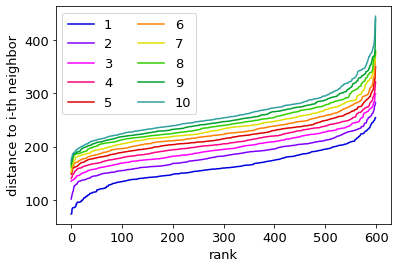

mean minimum distance between points:  162.34622464324366


In [27]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
distances, ind = nbrs.kneighbors(x)
dd=distances.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i%10-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ", mean_min_dist)

Functions provided during the lecture:

In [28]:
# functions provided in the lecture notebook
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

## 2.1 “eps” (ε) and “minPts” ($m_P$) in DBSCAN algorithm for clustering

Refine the grid with more values of ε and $m_P$ and plot a heat-map
showing the normalized mutual information (NMI) between true
and predicted clusters, similar to the one on the right.
Is the high NMI region showing a correlation between ε and $m_P$?

Note: In the lesson we have looked at the typical distance between
a point and its closest neighbor, but this does not say what the
typical distance is from the 2nd, 3rd , …, $m_P$-neighbor.
The plots of ranked distances to the i-th neighbor might also help
choose the ε for a given $i=m_P$ .

In [29]:
# define eps and mp grid
# based on typical min. distance between points
eps_range = np.arange(100, 800, 10)
min_sample_range = np.arange(5, 205, 5)

# list for results
nmi_results = []

# time the process for fun :D
ts = time.time()

for eps in eps_range:
    for mp in min_sample_range:

        # define & train model
        model = DBSCAN(eps=eps, min_samples=mp)
        model.fit(x)
        
        y_hat = model.labels_

        #calculate NMI
        nmi=NMI(y_hat, y)
        # append to results as dict
        nmi_results.append({"eps": eps, "mp": mp, "nmi": nmi})      
        
print("calculation took {:.2f}s".format(time.time()-ts))

calculation took 40.34s


Text(48.0, 0.5, '$\\epsilon$')

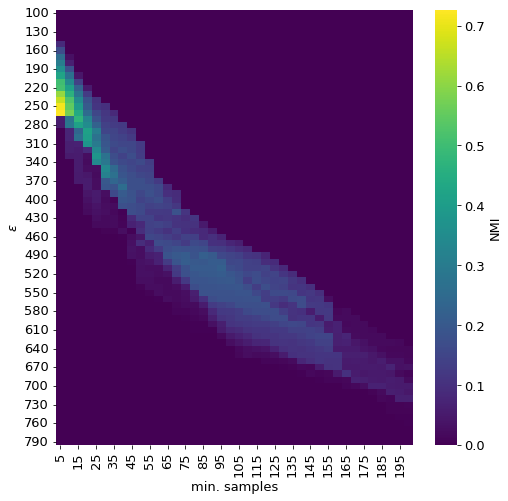

In [30]:
# convert to pandas dataframe
df = pd.DataFrame(nmi_results)

# plot heatmap
plt.figure(figsize=(8,8))
sns.heatmap(df.pivot(columns="mp", index="eps", values="nmi"),
            cmap="viridis",
            cbar_kws={'label': 'NMI'})
plt.xlabel("min. samples")
plt.ylabel("$\epsilon$")

The high-NMI region does indeed appear to show a correlation between $\varepsilon$ and $m_p$. The parameter $\varepsilon$ describes the maximum distance between points to be counted as neighbours, and $m_p$ is the minimum number of neighbours within $\varepsilon$ a point must have to be classified as a core point inside a cluster. Consider 2 cases:
1. **$\varepsilon$ too low / $m_p$ too high:**  Very few/no points are reachable or recognized as core points by the DBSCAN algorithm, so most points are interpreted as not reachable and thus noise points.
2. **$\varepsilon$ too high / $m_p$ too low:** Many (or in the worst case, all) points are classified as core points or are (directly) reachable, so the algorithm could interpret data as one large cluster (or very few, very large clusters).
  
The plot shows that better results can be a achieved with a sensible ratio between $\varepsilon$ and $m_P$, and that the range of successful combinations can be estimated well using the plot of typical minimum distances from above. It can also be seen that here, the highest NMI is achieved for lower values of $\varepsilon$ and $m_p$, which demonstrates that not only the ratio between the parameters matters. The best choices for $\varepsilon$ and $m_p$ depend on the given data, and should be carefully tuned for the algorithm to succeed.

## 2.2 Understanding the 12-dimensional data
Use the **principal component analysis (PCA)** to visualize the first components of the data.
Does it help understand its structure?

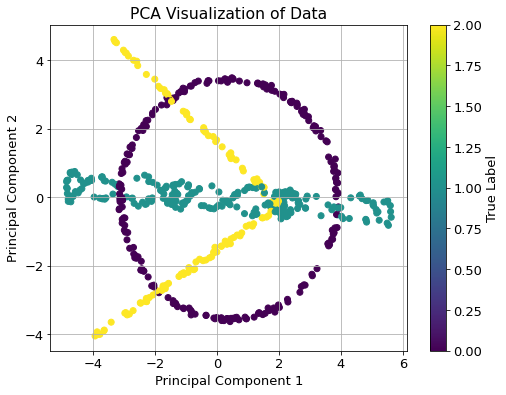

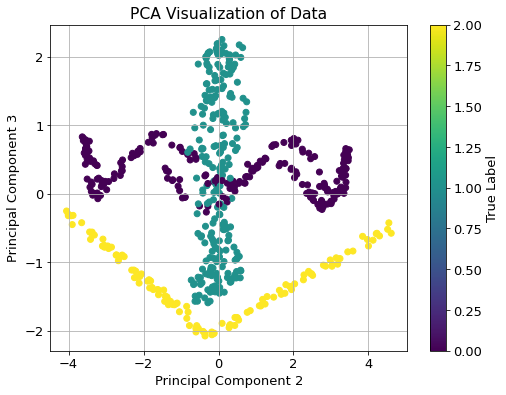

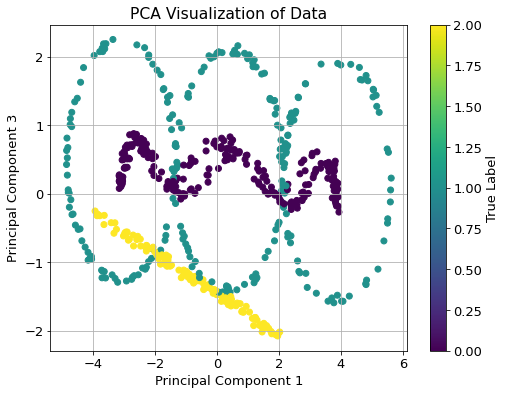

In [24]:
# perform PCA with 3 components
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')  

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Data')
plt.colorbar(label='True Label')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')  

plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('PCA Visualization of Data')
plt.colorbar(label='True Label')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap='viridis')  

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('PCA Visualization of Data')
plt.colorbar(label='True Label')
plt.grid(True)
plt.show()



As we see distinct clusters of colors without much overlap, it suggests that the PCA has done a good job at separating the different classes in the first two principal components, making the data structure more understandable.

## 2.3 Compare different clustering methods

a) Perform a k-means clustering of the data, with k=3. Does it work better than DBSCAN?
Why?

b) Perform a hierarchical clustering of the data and [plot the corresponding dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).
Does it work better than DBSCAN?


**To compare different clustering methods, we'll perform k-means clustering and hierarchical clustering on the data and compare their performance with DBSCAN. We'll evaluate the effectiveness of each method based on factors such as cluster quality, ease of use, and suitability for the dataset.**

#### K-Means

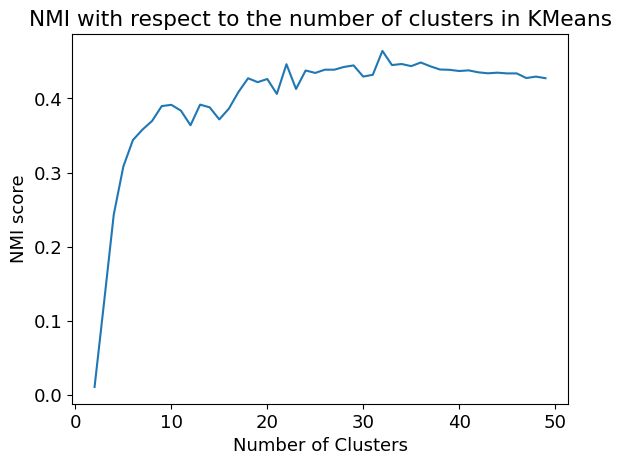

In [43]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore') # there is an annoying warning when using kmeans inside a loop

# we use a for loop to try different number of clusters
kmeans_nmi_arr = []
for n_clusters in range(2, 50):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans_labels = kmeans.fit_predict(X) 
    kmeans_nmi = normalized_mutual_info_score(y, kmeans_labels)
    kmeans_nmi_arr.append(kmeans_nmi)

    
plt.plot(list(range(2,50)), kmeans_nmi_arr)
plt.title('NMI with respect to the number of clusters in KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('NMI score')
plt.show()


**With Kmeans we got maximum 0.4 NMI when using 30-40 clusters which is less than the 0.7 value obtained with DBSCAN.**

#### Hierarchical clustering

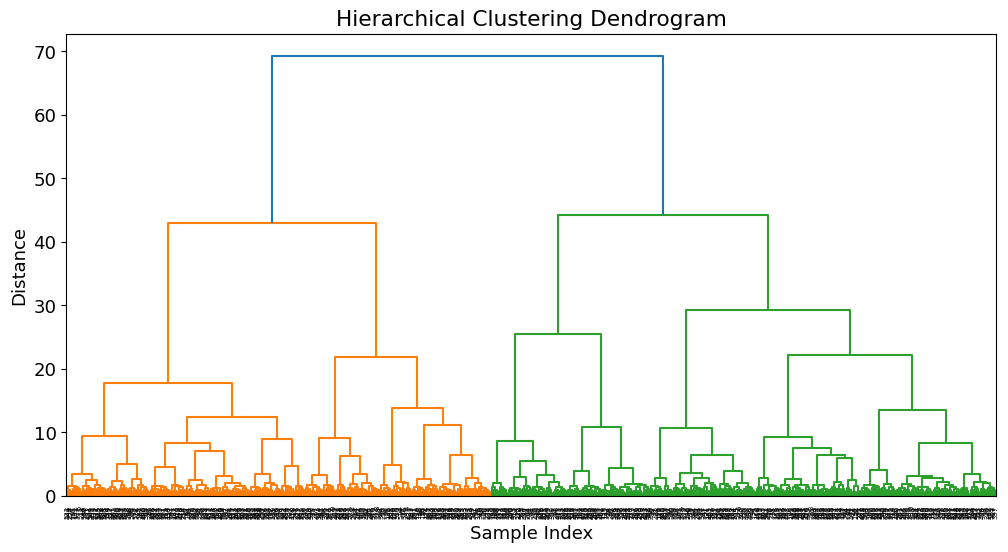

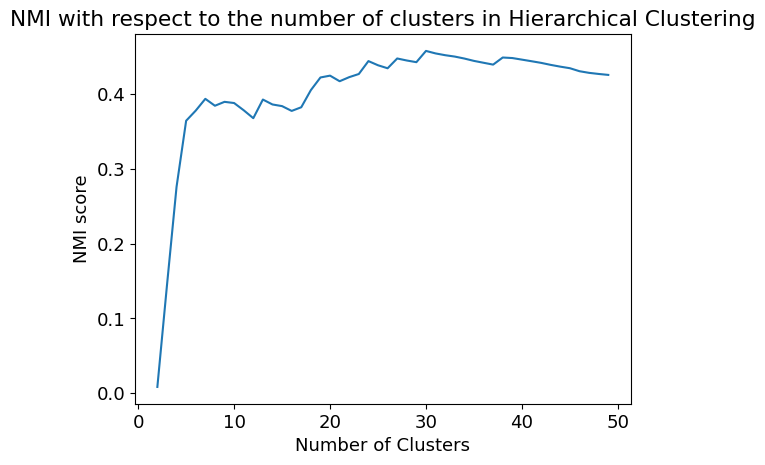

Max NMI Score For Hierarchical Clusering =  0.45762701902959657


In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

hc_nmi_arr = []
for n_clusters in range(2, 50):
    hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')
    hc_nmi_arr.append(normalized_mutual_info_score(y, hierarchical_labels))
    
plt.plot(list(range(2,50)), hc_nmi_arr)
plt.title('NMI with respect to the number of clusters in Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('NMI score')
plt.show()


print("Max NMI Score For Hierarchical Clusering = ", max(hc_nmi_arr))


**With this clustering we got maximum 0.4 NMI when using 20-40 clusters (similar to kMeans) which is less than the 0.7 value obtained with DBSCAN.**

## 2.4 OPTIONAL 
Visualize the data with other [methods from the scikit package](https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html#sphx-glr-auto-examples-manifold-plot-manifold-sphere-pyhttps://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html%23sphx-glr-auto-examples-manifold-plot-manifold-sphere-py).

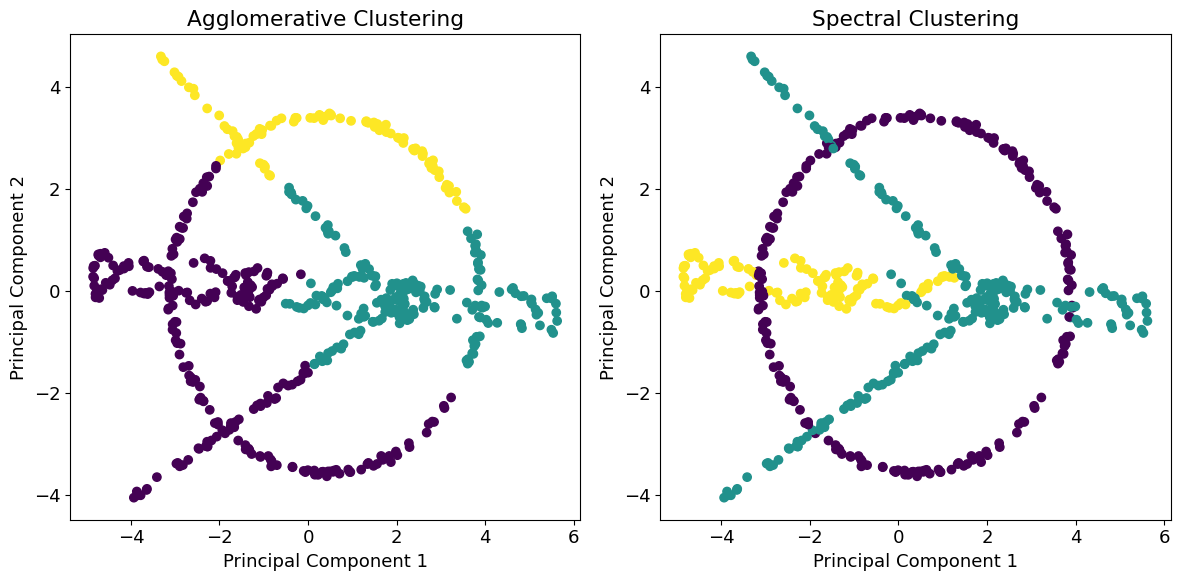

In [48]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(X)

# Perform Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=10)
spectral_labels = spectral_clustering.fit_predict(X)

# Visualize the clustering results
plt.figure(figsize=(12, 6))

# Agglomerative Clustering
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Spectral Clustering
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, cmap='viridis')
plt.title('Spectral Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [51]:
!pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3550 sha256=c66478623bba20bceb628cc8fbee9bffca8765d6ad09f85756105223adfcb1e8
  Stored in directory: c:\users\osama\appdata\local\pip\cache\wheels\82\d8\73\e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap


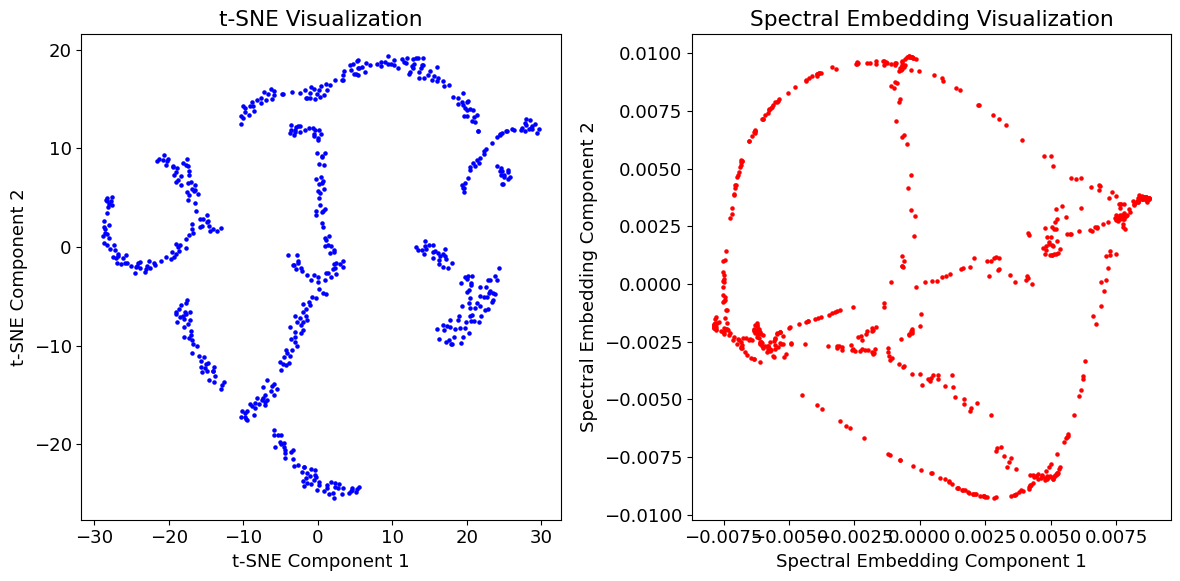

In [57]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
from sklearn.manifold import TSNE, SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from matplotlib.ticker import NullFormatter


# Visualize data using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize data using Spectral Embedding
spectral_embedding = SpectralEmbedding(n_components=2, random_state=42)
X_se = spectral_embedding.fit_transform(X)

# Plot the data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', s=5)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_se[:, 0], X_se[:, 1], c='red', s=5)
plt.title('Spectral Embedding Visualization')
plt.xlabel('Spectral Embedding Component 1')
plt.ylabel('Spectral Embedding Component 2')

plt.tight_layout()
plt.show()


In [58]:
print(X[0])

[ 0.22846914  0.53416215 -0.48348192 -1.03878321 -0.62699579 -0.30431936
 -1.19328985 -0.09729329  0.10659676 -0.62243565  0.095939   -0.31622658]


LLE (Standard)
LLE (Standard): 0.06 sec
LLE (Modified)
LLE (Modified): 0.15 sec
Isomap
Isomap: 0.12 sec
MDS
MDS: 1 sec
Spectral Embedding
Spectral Embedding: 0.041 sec
t-SNE
t-SNE: 1.3 sec


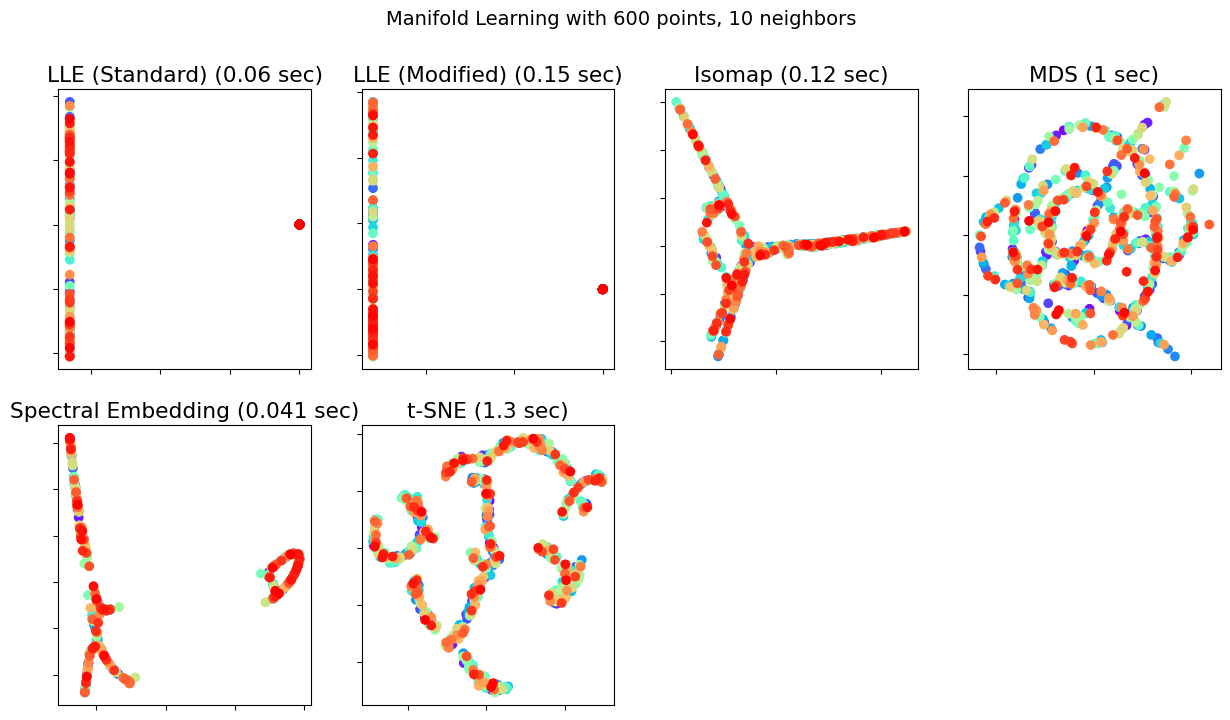

In [68]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import (
    LocallyLinearEmbedding,
    Isomap,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.utils import check_random_state

# Variables for manifold learning.
n_neighbors = 10
n_samples = X.shape[0]

# Generate your data (replace this with your actual data)
random_state = check_random_state(0)

# Plotting parameters
colors = np.linspace(0, 1, n_samples)

# Perform manifold learning with different methods
methods = [
    LocallyLinearEmbedding(method="standard"),
    LocallyLinearEmbedding(method="modified"),
    Isomap(),
    MDS(n_components=2, max_iter=100, n_init=1, random_state=42),
    SpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=42),
    TSNE(n_components=2, random_state=0),
]

method_names = [
    "LLE (Standard)",
    "LLE (Modified)",
    "Isomap",
    "MDS",
    "Spectral Embedding",
    "t-SNE",
]

plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (n_samples, n_neighbors),
    fontsize=14,
)

for i, method in enumerate(methods):
    t0 = time()
    print(method_names[i])
    trans_data = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (method_names[i], t1 - t0))

    ax = plt.subplot(2, 4, i + 1)
    plt.scatter(trans_data[:, 0], trans_data[:, 1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (method_names[i], t1 - t0))
    plt.axis("tight")
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

plt.show()
